This notebook will go through the pipeline for normalizing an fMRI dataset into the MNI template space.

Importing modules

In [5]:
%matplotlib inline
import os, shutil, errno
import sklearn.metrics
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt
from nipype.interfaces import fsl, ants
from nipype.caching import Memory

mem = Memory(base_dir='.')

try:
    datadir=os.environ['FMRIBOOKBASE']
    assert os.path.exists(datadir)
except:
    raise Exception('You must first set the environment variable FMRIBOOKBASE')

print 'Using data from',datadir

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
def force_symlink(file1, file2):
    try:
        os.symlink(file1, file2)
    except OSError, e:
        if e.errno == errno.EEXIST:
            os.remove(file2)
            os.symlink(file1, file2)

Using data from /Users/poldrack/Dropbox/Documents/Books/HandbookOfFMRIAnalysis/fmri-handbook-2e


Setting up variables

In [3]:
subject='ses014'  
# note - we have to use the anatomy from a different session'
anat_subject='ses018'
bolddir=os.path.join(datadir,'ds031/sub00001',subject,
        'functional')

meanbold_unwarped_file=os.path.join(results_dir, "meanbold_unwarped.nii.gz")
meanbold=os.path.join(results_dir, "meanbold.nii.gz")
fmapmag=os.path.join(results_dir, "fmapmag.nii.gz")
fmapmagbrain=os.path.join(results_dir, "fmapmagbrain.nii.gz")
fmap=os.path.join(results_dir, "fieldmap.nii.gz")
bold_file=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold_mcf_brain_unwarped.nii.gz')
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1file=os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

In [4]:
datadir

'/Users/poldrack/data_unsynced/myconnectome/sub00001'

## Bias field correction of the T1

In [4]:
bias_field_correcton = mem.cache(ants.N4BiasFieldCorrection)
bias_field_correcton_results = bias_field_correcton(input_image = t1file, 
                                                    dimension = 3,
                                                    save_bias = True)
bias_field_correcton_results.outputs

INFO:workflow:Executing node 806a4ed0b080946a11dfa6ece7d7bcce in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce
INFO:workflow:Collecting precomputed outputs



bias_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce/sub00001_ses018_T1w_001_bias.nii.gz
output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-segmentation-N4BiasFieldCorrection/806a4ed0b080946a11dfa6ece7d7bcce/sub00001_ses018_T1w_001_corrected.nii.gz

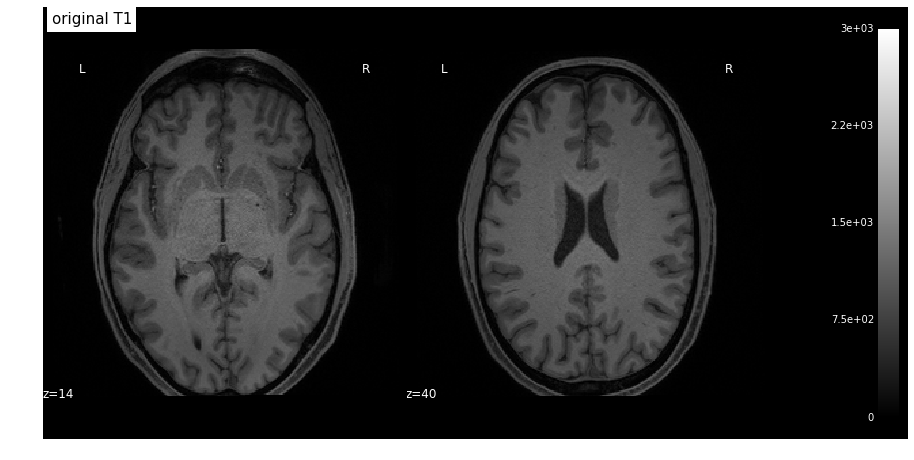

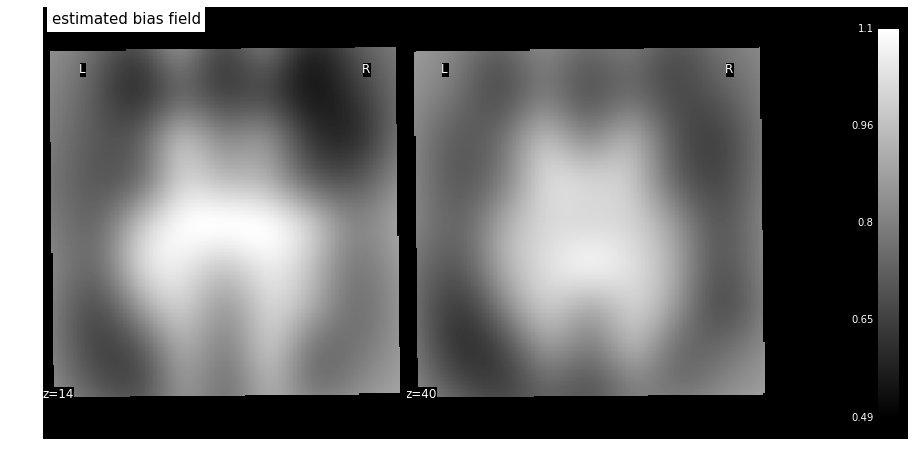

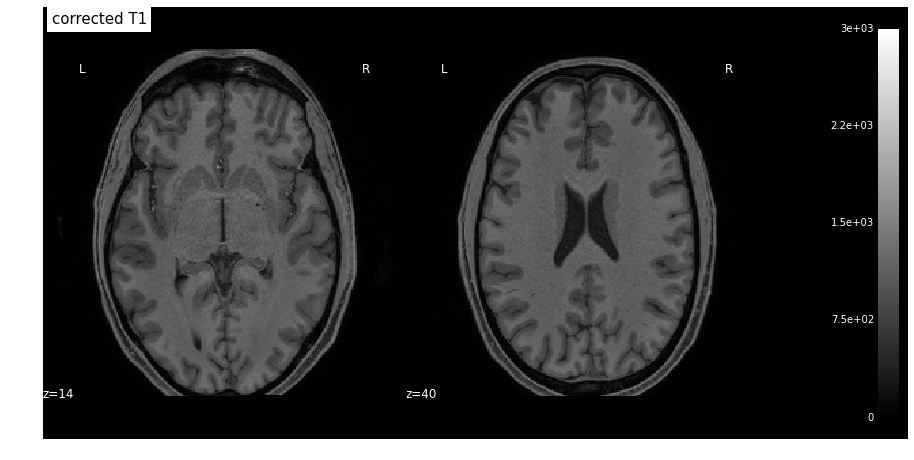

In [5]:
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(t1file, colorbar=True, vmax=3000, display_mode='z', cut_coords=(14, 40), 
                           title="original T1", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.bias_image, display_mode='z', 
                          cut_coords=(14, 40), colorbar=True, title="estimated bias field", figure=fig)
fig = plt.figure(figsize=(12,6))
nilearn.plotting.plot_anat(bias_field_correcton_results.outputs.output_image, colorbar=True, 
                           vmax=3000, display_mode='z', cut_coords=(14, 40), title="corrected T1", figure=fig)

__Exercise__: Compute the difference between the original and bias-corrected image, and display the difference in the same two slices as above.

## Brain extraction using BET

In [6]:
bet = mem.cache(fsl.BET)
bet_results = bet(in_file=bias_field_correcton_results.outputs.output_image,
                  mask=True,
                  frac=0.3)
bet_results.outputs

INFO:workflow:Executing node 4f22a1a8caec43e1a0155b3efee785c6 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/4f22a1a8caec43e1a0155b3efee785c6
INFO:workflow:Collecting precomputed outputs



inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/4f22a1a8caec43e1a0155b3efee785c6/sub00001_ses018_T1w_001_corrected_brain_mask.nii.gz
meshfile = <undefined>
out_file = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-BET/4f22a1a8caec43e1a0155b3efee785c6/sub00001_ses018_T1w_001_corrected_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_mask_file = <undefined>

Visualize brain mask overlaid on anatomy

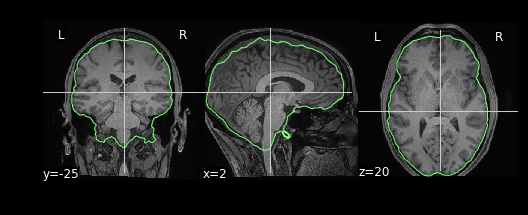

In [7]:
mask_display=nilearn.plotting.plot_epi(t1file,cmap='gray')
mask_display.add_contours(bet_results.outputs.mask_file, levels=[.5]) 

## Combined corregistration and fieldmap unwarping using boundary based registration

Please note that we are using mean EPI image instead of whole time series.

In [8]:
epi_reg = mem.cache(fsl.EpiReg)
epi_reg_results = epi_reg(epi=meanbold,
                          t1_head=bias_field_correcton_results.outputs.output_image,
                          t1_brain=bet_results.outputs.out_file,
                          fmap=fmap,
                          fmapmag=fmapmag,
                          fmapmagbrain=fmapmagbrain,
                          echospacing=2.6/10000.0,
                          pedir='y',
                          out_base="epi2struct")
force_symlink(epi_reg_results.outputs.fullwarp, os.path.join(results_dir, "epi_to_t1_warp.nii.gz"))
epi_reg_results.outputs

INFO:workflow:Executing node 086040cb9311423338489106fdd975de in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de
INFO:workflow:Collecting precomputed outputs



epi2str_inv = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de/epi2struct_inv.mat
epi2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de/epi2struct.mat
fmap2epi_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de/epi2struct_fieldmaprads2epi.mat
fmap2str_mat = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de/epi2struct_fieldmap2str.mat
fmap_epi = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de/epi2struct_fieldmaprads2epi.nii.gz
fmap_str = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-epi-EpiReg/086040cb9311423338489106fdd975de/epi2

Boundary based registration used grey/white matter interface to corregister EPI and T1 images. This boundary has been estimated from the T1 image.

In [3]:
mask_display=nilearn.plotting.plot_epi(data['T1'],cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

NameError: name 'data' is not defined

To evaluate the quality of the corregistration lets overlay the grey-white matter border on top of the EPI image.

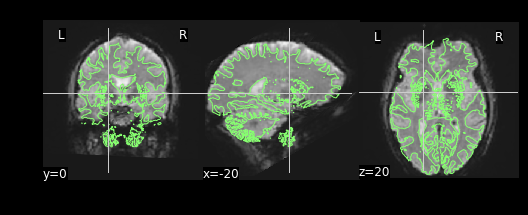

In [10]:
mask_display=nilearn.plotting.plot_epi(epi_reg_results.outputs.out_file,cmap='gray', cut_coords=(-20,0,20))
mask_display.add_contours(epi_reg_results.outputs.wmseg, levels=[.5]) 

## Normalization (T1 to MNI corregistration) using ANTs

To save time we will reduce the number of iterations.

In [11]:
ants_reg = mem.cache(ants.Registration)
ants_results = ants_reg(fixed_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                    moving_image = bet_results.outputs.out_file,
                    transforms = ['Translation', 'Rigid', 'Affine', 'SyN'],
                    transform_parameters = [(0.1,), (0.1,), (0.1,), (0.2, 3.0, 0.0)],
                    #number_of_iterations = ([[10000, 111110, 11110]]*3 +
                    #                [[100, 50, 30]]),
                    number_of_iterations = ([[10, 10, 10]]*3 +
                                    [[1, 5, 3]]),
                    dimension = 3,
                    write_composite_transform = True,
                    metric = ['Mattes'] * 3 + [['Mattes', 'CC']],
                    metric_weight = [1] * 3 + [[0.5, 0.5]],
                    radius_or_number_of_bins = [32] * 3 + [[32, 4]],
                    sampling_strategy = ['Regular'] * 3 + [[None, None]],
                    sampling_percentage = [0.3] * 3 + [[None, None]],
                    convergence_threshold = [1.e-8] * 3 + [-0.01],
                    convergence_window_size = [20] * 3 + [5],
                    smoothing_sigmas = [[4, 2, 1]] * 3 + [[1, 0.5, 0]],
                    sigma_units = ['vox'] * 4,
                    shrink_factors = [[6, 4, 2]] + [[3, 2, 1]]*2 + [[4, 2, 1]],
                    use_estimate_learning_rate_once = [True] * 4,
                    use_histogram_matching = [False] * 3 + [True],
                    initial_moving_transform_com = True,
                    output_warped_image = True)
force_symlink(ants_results.outputs.composite_transform, os.path.join(results_dir, "t1_to_mni_warp.h5"))
ants_results.outputs

/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input sigma_units requires inputs: smoothing_sigmas
  warn(msg)
/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input sampling_percentage requires inputs: sampling_strategy
  warn(msg)
/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input convergence_threshold requires inputs: number_of_iterations
  warn(msg)
/home/vagrant/miniconda/lib/python2.7/site-packages/nipype/interfaces/base.py:412: UserWarning: Input metric_weight requires inputs: metric
  warn(msg)
INFO:workflow:Executing node 329292f6c214007d70da3e81859c9cb1 in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/329292f6c214007d70da3e81859c9cb1
INFO:workflow:Collecting precomputed outputs



composite_transform = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/329292f6c214007d70da3e81859c9cb1/transformComposite.h5
forward_invert_flags = []
forward_transforms = []
inverse_composite_transform = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/329292f6c214007d70da3e81859c9cb1/transformInverseComposite.h5
inverse_warped_image = <undefined>
reverse_invert_flags = []
reverse_transforms = []
save_state = <undefined>
warped_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-registration-Registration/329292f6c214007d70da3e81859c9cb1/transform_Warped.nii.gz

Lets plot the normalized subject brain next to the MNI template.

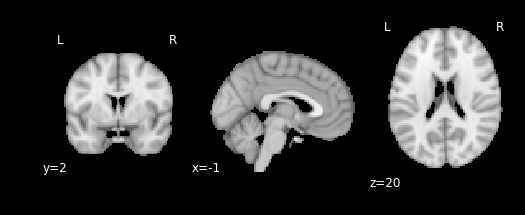

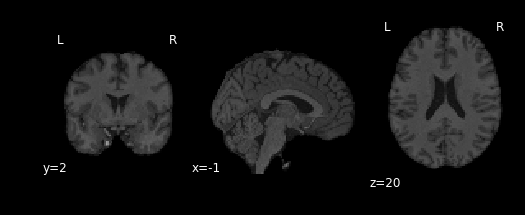

In [12]:
nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                           cut_coords=(-1,2,20), draw_cross=False)
nilearn.plotting.plot_anat(ants_results.outputs.warped_image,
                           cut_coords=(-1,2,20), draw_cross=False)

Again we can plot grey-white matter outline as an overlay to asses the quality of the corregistration. First we need to warp the WM segmentation file to the MNI space using just estimated transform

INFO:workflow:Executing node 836a8c5081de696291db568481e0d87a in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/836a8c5081de696291db568481e0d87a
INFO:workflow:Collecting precomputed outputs


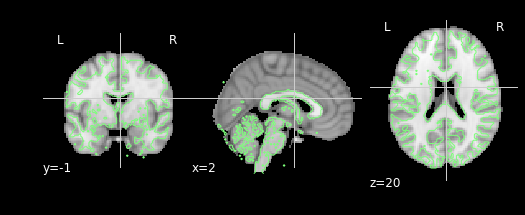

In [13]:
T1_to_MNI_warp = mem.cache(ants.ApplyTransforms)
T1wm_to_MNI_warp_results = T1_to_MNI_warp(input_image = epi_reg_results.outputs.wmseg,
                                          reference_image = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                          interpolation = "NearestNeighbor",
                                          transforms = ants_results.outputs.composite_transform)

fig = nilearn.plotting.plot_anat(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))
fig.add_contours(T1wm_to_MNI_warp_results.outputs.output_image, levels=[.5]) 

Note that we have not yet combined the two transformations. We will do that when it comes to group level analysis. We will apply the combined transformations to single subject (first level) contrast maps.

We can test this procedure on the mean EPI image

In [14]:
epi_to_t1 = mem.cache(fsl.ApplyWarp)
epi_to_t1_results = epi_to_t1(in_file=meanbold,
                              ref_file=t1file,
                              field_file=epi_reg_results.outputs.fullwarp,
                              interp="spline")

t1_to_mni = mem.cache(ants.ApplyTransforms)
t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                              reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                              transforms=ants_results.outputs.composite_transform,
                              interpolation="BSpline")
t1_to_mni_results.outputs

INFO:workflow:Executing node f56abc4e6068ad938d83bedece8d046c in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/f56abc4e6068ad938d83bedece8d046c
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node c7584881dc42c1c62724409b8b58dbbd in dir: /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/c7584881dc42c1c62724409b8b58dbbd
INFO:workflow:Collecting precomputed outputs



output_image = /home/vagrant/fmri-analysis-vm/analysis/normalization/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/c7584881dc42c1c62724409b8b58dbbd/meanbold_warp_trans.nii.gz

Now let's look at the warp field from ANTS

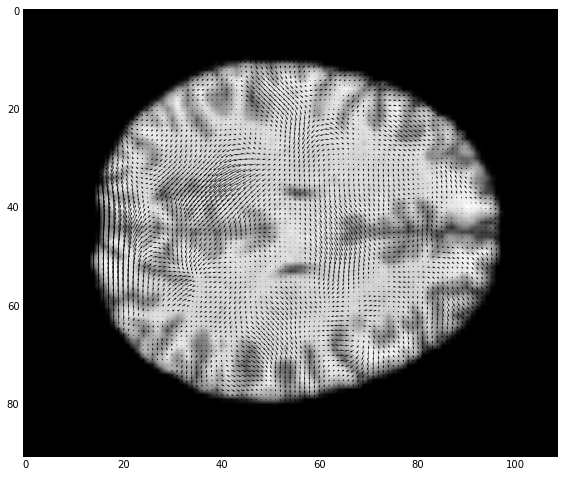

In [46]:
import h5py
composite_transform=h5py.File(ants_results.outputs.composite_transform,  "r")
transform_group=composite_transform['TransformGroup']
warpfield=numpy.reshape(transform_group['5']['TranformParameters'],(91,109,91,3))

warped_t1=nibabel.load(ants_results.outputs.warped_image)
warped_t1_data=warped_t1.get_data()
slicenum=50
plt.figure(figsize=(12,8))
plt.imshow(warped_t1_data[:,:,slicenum],cmap='gray')
plt.quiver(warpfield[:,:,slicenum,0],warpfield[:,:,slicenum,1],linewidths=0.001,width=0.001)

__Exercise__: Zoom into a part of the image and show a close-up of the warp field around the anterior cingulate cortex.



Finally we can interactivelly interrogate the three images (EPI, T1, MNI tempalate) in fslview

In [48]:
!fslview {t1_to_mni_results.outputs.output_image} {os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz')} {ants_results.outputs.warped_image}